为什么需要创建代理？因为大多数情况下，开发者需要用自己的自定义代理或工具去实现特定的业务功能。



此部分，将会使用LangChain Expression Language从零开始创建代理。然后，将自定义工具，并在自定义循环中运行它（我们还将展示如何使用标准的LangChain AgentExecutor）。

## 创建代理、工具

首先，需要创建代理，它是一种链，负责确定下一步采取什么行动。

在这个示例中，使用OpenAI Function Calling来创建此代理。这通常是创建代理的最可靠方式。
在这个案例中，我们将为Agent提供一个计算单词长度的工具。这个工具实际上很有用，因为LLM通常会由于tokenization而计算错误。我们会先创建这个工具，然后将展示如何添加内存。内存是启用对话所必需的。

首先，加载用于控制代理的LLM。

In [ ]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(temperature=0)

接下来，定义一些要使用的工具。这里编写一个非常简单的Python函数，用于计算传入单词的长度。

In [ ]:
from langchain.agents import tool

@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)

tools = [get_word_length]

然后，创建prompt。由于OpenAI Function Calling已经针对工具使用进行了微调，所以我们几乎不需要关于如何进行推理或如何输出格式的任何说明。我们只需要两个输入变量：input（用于用户问题）和agent_scratchpad（用于存储任何先前的步骤）。

In [ ]:
from langchain.prompts 
import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are very powerful assistant, but bad at calculating lengths of words."),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

代理如何知道可以使用哪些工具？这些工具作为单独的参数传递，因此我们可以将它们绑定为关键字参数传递给LLM。

In [ ]:
from langchain.tools.render 
import format_tool_to_openai_function

llm_with_tools = llm.bind(
    functions=[format_tool_to_openai_function(t) for t in tools]
)

将这些组件放在一起，现在就可以创建代理了。导入两个最后的实用程序函数：一个用于将中间步骤格式化为消息的组件，另一个用于将输出消息转换为代理操作/代理完成。

In [ ]:
from langchain.agents.format_scratchpad 
import format_to_openai_functions

from langchain.agents.output_parsers 
import OpenAIFunctionsAgentOutputParser

agent = {
    "input": lambda x: x["input"],
    "agent_scratchpad": lambda x: format_to_openai_functions(x['intermediate_steps'])
} | prompt | llm_with_tools | OpenAIFunctionsAgentOutputParser()

input：用于接收用户输入。这里的 lambda 表示定义了一个简单函数（输入参数为x），可以忽略；

agent_scratchpad：从输入数据中提取了一个名为 "intermediate_steps" 的字段，并将其传递给 format_to_openai_functions 函数，该函数的作用是将中间步骤转化为 OpenAI 函数的形式

“ | ”是管道操作符：在Python中，管道操作符 | 可以用来连接多个命令,前一个命令的输出作为后一个命令的输入,实现流水线的效果。

OpenAIFunctionsAgentOutputParser()：创建了一个实例，它是一个用于解析模型输出的类。这个步骤的目的是处理模型生成的输出并解析其中的信息。



现在我们完成了一个自定义代理，让我们试验一下！传入一个简单的问题和空的中间步骤，看看它返回了什么：

In [ ]:
agent.invoke({
    "input": "how many letters in the word educa?",
    "intermediate_steps": []
})

结果输出

AgentActionMessageLog(tool='get_word_length', tool_input={'word': 'educa'}, log="\nInvoking: `get_word_length` with `{'word': 'educa'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_word_length', 'arguments': '{\n  "word": "educa"\n}'}})])

可以看到它回应了一个要执行的AgentAction（准确的说是AgentActionMessageLog——AgentAction的一个子类，它也会跟踪完整的消息记录）

## 创建运行时环境Runtime

现在需要为其编写运行时环境（runtime）。最简单的一种是连续循环，调用代理，然后执行操作，并重复，直到返回AgentFinish。代码如下：

In [ ]:
from langchain.schema.agent import AgentFinish
intermediate_steps = []
while True:
    output = agent.invoke({
        "input": "how many letters in the word educa?",
        "intermediate_steps": intermediate_steps
    })
    if isinstance(output, AgentFinish):
        final_result = output.return_values["output"]
        break
    else:
        print(output.tool, output.tool_input)
        tool = {
            "get_word_length": get_word_length
        }[output.tool]
        observation = tool.run(output.tool_input)
        intermediate_steps.append((output, observation))
print(final_result)

可成功输出结果：

get_word_length {'word': 'educa'}

There are 5 letters in the word "educa".

我们可以将上述runtime过程简化一点：导入并使用AgentExecutor类。它将所有上述内容打包在一起，并添加了错误处理、提前停止、跟踪以及其他提高质量的手段：

In [ ]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [ ]:
# 测试一下
agent_executor.invoke({"input": "how many letters in the word educa?"})

输出结果如下：
 > Entering new AgentExecutor chain...

    Invoking: `get_word_length` with `{'word': 'educa'}`

    5

    There are 5 letters in the word "educa".

    > Finished chain.

    'There are 5 letters in the word "educa".'

现在我们成功创建了一个代理。

## 增加内存，记忆之前的交互

上述代理是无状态的，因此需要通过添加内存来增加记忆：

在提示中添加一个用于存储内存变量的位置。

跟踪聊天历史记录。

首先，在prompt中添加一个键为"chat_history"的占位符，用于存储之前的对话历史。注意，我们将其放在新的用户输入前面（以遵循对话流程）。

In [ ]:
from langchain.prompts import MessagesPlaceholder

MEMORY_KEY = "chat_history"
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are very powerful assistant, but bad at calculating lengths of words."),
    MessagesPlaceholder(variable_name=MEMORY_KEY),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

然后，设置一个列表来跟踪聊天历史记录：

In [ ]:
from langchain.schema.messages import HumanMessage, AIMessage
chat_history = []

然后再将上述内容放在一起：

In [ ]:
agent = {
    "input": lambda x: x["input"],
    "agent_scratchpad": lambda x: format_to_openai_functions(x['intermediate_steps']),
    "chat_history": lambda x: x["chat_history"]
} | prompt | llm_with_tools | OpenAIFunctionsAgentOutputParser()
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


在运行时，需要跟踪聊天历史记录中的输入和输出：

In [ ]:
input1 = "how many letters in the word educa?"
result = agent_executor.invoke({"input": input1, "chat_history": chat_history})
chat_history.append(HumanMessage(content=input1))
chat_history.append(AIMessage(content=result['output']))
agent_executor.invoke({"input": "is that a real word?", "chat_history": chat_history})

运行结果为：

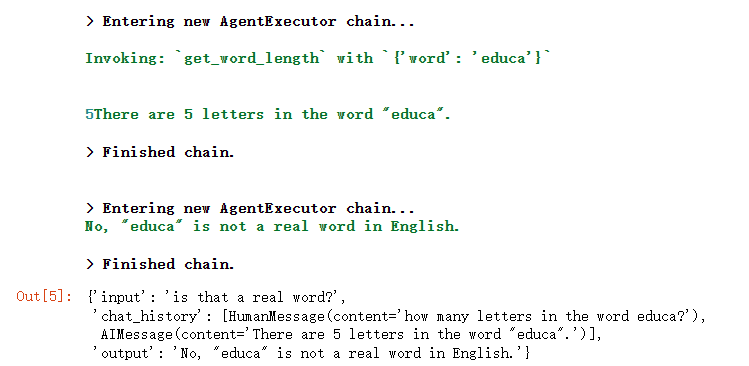

至此，我们已经运行了第一个端到端代理。要深入了解，接下来可以：

查看所有支持的不同代理类型

了解AgentExecutor的所有控件

查看langchain提供的所有现成工具包的完整列表

探索支持的所有单个工具

# 代码完整版本如下：

# 无记忆版本

In [ ]:
from langchain.chat_models import ChatOpenAI

# 设置 OpenAI API 密钥
os.environ["OPENAI_API_KEY"] = "KEY"

# 创建 ChatOpenAI 实例，配置模型参数
llm = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0,
    model_name='gpt-3.5-turbo'
)

# 自定义tool
from langchain.agents import tool

@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)

tools = [get_word_length]

# 设置prompt
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are very powerful assistant, but bad at calculating lengths of words."),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

# 绑定工具作为关键词参数，传递给LLM
from langchain.tools.render import format_tool_to_openai_function

llm_with_tools = llm.bind(
    functions=[format_tool_to_openai_function(t) for t in tools]
)

# 创建代理
from langchain.agents.format_scratchpad import format_to_openai_functions
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

agent = {
    "input": lambda x: x["input"],
    "agent_scratchpad": lambda x: format_to_openai_functions(x['intermediate_steps'])
} | prompt | llm_with_tools | OpenAIFunctionsAgentOutputParser()

# agent.invoke({
#     "input": "how many letters in the word educa?",
#     "intermediate_steps": []
# })

# 创建runtime（手动版）和下面的选一个即可
# from langchain.schema.agent import AgentFinish
# intermediate_steps = []
# while True:
#     output = agent.invoke({
#         "input": "how many letters in the word educa?",
#         "intermediate_steps": intermediate_steps
#     })
#     if isinstance(output, AgentFinish):
#         final_result = output.return_values["output"]
#         break
#     else:
#         print(output.tool, output.tool_input)
#         tool = {
#             "get_word_length": get_word_length
#         }[output.tool]
#         observation = tool.run(output.tool_input)
#         intermediate_steps.append((output, observation))
# print(final_result)

# 创建runtime（导入并使用AgentExecutor类）
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor.invoke({"input": "how many letters in the word educa?"})

结果输出如下：

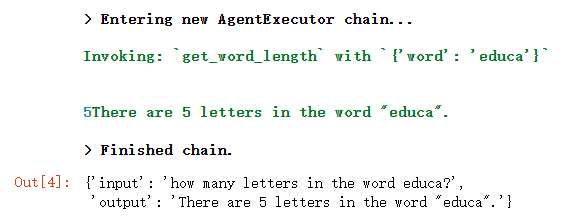

# 有记忆版本

In [ ]:
from langchain.chat_models import ChatOpenAI

# 设置 OpenAI API 密钥
os.environ["OPENAI_API_KEY"] = "KEY"

# 创建 ChatOpenAI 实例，配置模型参数
llm = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0,
    model_name='gpt-3.5-turbo'
)

# 自定义tool
from langchain.agents import tool

@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)

tools = [get_word_length]


# 修改 prompt 增加记忆
from langchain.prompts import MessagesPlaceholder

MEMORY_KEY = "chat_history"
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are very powerful assistant, but bad at calculating lengths of words."),
    MessagesPlaceholder(variable_name=MEMORY_KEY),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

# 绑定工具作为关键词参数，传递给LLM
from langchain.tools.render import format_tool_to_openai_function

llm_with_tools = llm.bind(
    functions=[format_tool_to_openai_function(t) for t in tools]
)

# 设置历史记录列表
from langchain.schema.messages import HumanMessage, AIMessage
chat_history = []

# 创建代理
from langchain.agents.format_scratchpad import format_to_openai_functions
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

agent = {
    "input": lambda x: x["input"],
    "agent_scratchpad": lambda x: format_to_openai_functions(x['intermediate_steps']),
    "chat_history": lambda x: x["chat_history"]
} | prompt | llm_with_tools | OpenAIFunctionsAgentOutputParser()


# 创建runtime（导入并使用AgentExecutor类）
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


# 运行代理
input1 = "how many letters in the word educa?"
result = agent_executor.invoke({"input": input1, "chat_history": chat_history})
chat_history.append(HumanMessage(content=input1))
chat_history.append(AIMessage(content=result['output']))
agent_executor.invoke({"input": "is that a real word?", "chat_history": chat_history})

输出结果如下，可见红框部分是记忆：

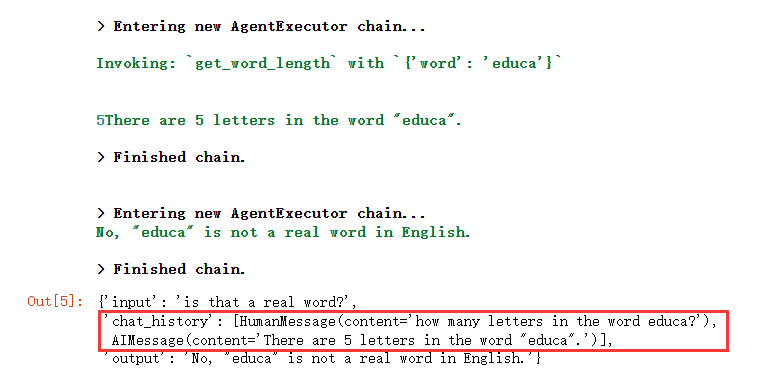